In [1]:
import matplotlib as mpl

font = {'family' : 'sans',
        'size'   : 12}

mpl.rc('font', **font)
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe

import numpy as np
import glob, os
from cmcrameri import cm
from proteus.atmos_clim.common import read_ncdf_profile


In [2]:
output_dir = "data/article_data/jgr_proteus_grid/fiducial/"
tmin = 100

In [3]:
%matplotlib inline

In [4]:
# Gather data files
output_files = glob.glob(output_dir+"/data/*_atm.nc")
output_times = [ int(str(f).split('/')[-1].split('_')[0]) for f in output_files]
sort_mask = np.argsort(output_times)
sorted_files = np.array(output_files)[sort_mask]
sorted_times = np.array(output_times)[sort_mask]

# Parse NetCDF files
stride = 1
sorted_p = []
sorted_t = []
sorted_z = []
sorted_y = []
for i in range(0,len(sorted_files),stride):
    time = sorted_times[i]
    if time < tmin:
        continue
    sorted_y.append(sorted_times[i]/1e6)

    prof = read_ncdf_profile(sorted_files[i])
    sorted_p.append(prof["p"] / 1.0e5)  # Convert Pa -> bar
    sorted_t.append(prof["t"])
    sorted_z.append(prof["z"] / 1.0e3)  # Convert m -> km
nfiles = len(sorted_p)

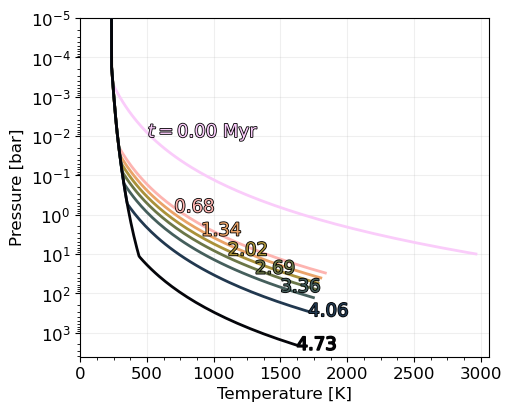

In [5]:

nlines = 8
al=1.0
lw=2

# Initialise plot
scale = 1.1
fig,ax = plt.subplots(1,1,figsize=(4.8*scale,4*scale))
ax.set_ylabel("Pressure [bar]")
ax.set_xlabel("Temperature [K]")
ax.invert_yaxis()
ax.set_yscale("log")

# Colour mapping
norm = mpl.colors.Normalize(vmin=sorted_y[0], vmax=sorted_y[-1])
sm = plt.cm.ScalarMappable(cmap=cm.batlowK_r, norm=norm)
sm.set_array([])

# Plot times 
tgt_times = np.linspace(0,sorted_y[-1],nlines)
plt_idx = []
for i,t in enumerate(tgt_times):
    i_near = np.argmin(np.abs(sorted_y - t))
    plt_idx.append(i_near)

# Plot data
for i,idx in enumerate(plt_idx):
    time = sorted_y[idx]
    c = sm.to_rgba(time)
    ax.plot(sorted_t[idx], sorted_p[idx], color=c, alpha=al, zorder=3, lw=lw)

    str_time = "%.2f"%time

    if i == 0:
        str_time = "$t=$%s Myr"%str_time

    str_idx = np.argmin(np.abs(sorted_t[idx] - 500 - 200*i))
    txt = ax.text(sorted_t[idx][str_idx]+5,sorted_p[idx][str_idx], str_time, 
                    color=c, fontsize=13,
                    verticalalignment="center", horizontalalignment="left", zorder=4)
    txt.set_path_effects([pe.withStroke(linewidth=1.2, foreground='k')])
        

# Grid
ax.grid(alpha=0.2, zorder=2)
ax.set_xlim(0,np.amax(sorted_t)+100)
ax.xaxis.set_minor_locator(MultipleLocator(base=125))

ax.set_ylim(np.amax(sorted_p)*3, np.amin(sorted_p)/3)
ax.yaxis.set_major_locator(LogLocator())
ax.set_ylim(top=np.amin(sorted_p[-1]), bottom=np.amax(sorted_p[-1]*2))


plt.show()

# Save plot
for fmt in ["pdf","png"]:
    fname = "output/plot_atmosphere_cbar.%s"%fmt
    fig.savefig(fname, bbox_inches='tight', dpi=200)